# Road Traffic Accidents in Switzerland

In this project, we work with the data from Switzerland's road accidents.

In [1]:
import helpers
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Scraping the data

Writing to the "Office Fédéral des Statistiques" was unsuccessful, so we resort to web scraping.

The scraped data comes from http://map.donneesaccidents.ch/ (or https://map.geo.admin.ch/?topic=vu&lang=fr&bgLayer=ch.swisstopo.pixelkarte-grau&layers=ch.astra.unfaelle-personenschaeden_alle&layers_timestamp=&catalogNodes=1318, after redirections).

![Map](Resources/images/swissaccidentsmap.png)

#### Layers

The map contains the following layers:
* Accidents with personal injury
* Accidents with fatalities
* Accidents involving a pedestrian
* Accidents involving a bicycle
* Accidents involving a motorcycle

There is no information regarding accidents where nobody is unjured, since by law only accidents in which someone is injured require police intervention. This explains why only these are archived.

#### Getting detailed accident data

The map only displays markers for each accident. When one or more markers are selected, a web query retrieves the information related to the selected markers. Using postman, we analysed such queries and found a way to select several or all markers on the map.

This is achieved by defining a rectangle, and querying for all markers inside it. We declare a rectangle that encompasses all Switzerland. This behaviour can be simulated on the browser by holding the ctrl key (or cmd on mac) and dragging a rectangle over the map.
The returned data is paginated, so it is necessary to go over all the pages to obtain all detailed accident data.

Example query parameters:
```
geometry:443999.04209536605,39001.6733318335,870499.0420953662,303001.67333183356
geometryFormat:geojson
geometryType:esriGeometryEnvelope
imageDisplay:1536,759,96
lang:en
layers:all:LAYER_PARAM
offset:200
mapExtent:269999.04209536605,9501.673331833561,1037999.042095366,389001.67333183356
returnGeometry:true
tolerance:5
```

`LAYER_PARAM` can be replaced by the appropriate layer name and `offset` is optional.

In [12]:
# Import raw data from http://map.donneesaccidents.ch/
data = helpers.import_data()

Scraping layer ch.astra.unfaelle-personenschaeden_alle
Layer scraped : 90600 records
Scraping layer ch.astra.unfaelle-personenschaeden_getoetete
Layer scraped : 1343 records
Scraping layer ch.astra.unfaelle-personenschaeden_fussgaenger
Layer scraped : 11738 records
Scraping layer ch.astra.unfaelle-personenschaeden_fahrraeder
Layer scraped : 18104 records
Scraping layer ch.astra.unfaelle-personenschaeden_motorraeder
Layer scraped : 19676 records
Scraped data: 141461 records


In [18]:
pickle.dump(data, open('data/data_raw.pickle', 'wb'))

In [30]:
raw_df = pd.DataFrame(data)
raw_df.sample(5)

,bbox,featureId,geometry,geometryType,id,layerBodId,layerName,properties,type
40540,"[711582.0, 237485.0, 711582.0, 237485.0]",2288AB5886B801E0E0530A83942732C3,"{'coordinates': [[711582.0, 237485.0]], 'type'...",Feature,2288AB5886B801E0E0530A83942732C3,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,{'severitycategory_fr': 'accident avec blessés...,Feature
89667,"[650379.0, 211879.0, 650379.0, 211879.0]",FDC33805335300FCE0430A8394272D3F,"{'coordinates': [[650379.0, 211879.0]], 'type'...",Feature,FDC33805335300FCE0430A8394272D3F,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,{'severitycategory_fr': 'accident avec blessés...,Feature
16808,"[786378.0, 191612.0, 786378.0, 191612.0]",A7397F33ADD40190E0430A8394270190,"{'coordinates': [[786378.0, 191612.0]], 'type'...",Feature,A7397F33ADD40190E0430A8394270190,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,{'severitycategory_fr': 'accident avec blessés...,Feature
17136,"[646844.0, 227879.0, 646844.0, 227879.0]",0170898A08D80126E0530A83942700AE,"{'coordinates': [[646844.0, 227879.0]], 'type'...",Feature,0170898A08D80126E0530A83942700AE,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,{'severitycategory_fr': 'accident avec blessés...,Feature
38940,"[567319.0, 122230.0, 567319.0, 122230.0]",AF53FCC8B4E001A0E0430A83942701A0,"{'coordinates': [[567319.0, 122230.0]], 'type'...",Feature,AF53FCC8B4E001A0E0430A83942701A0,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,{'severitycategory_fr': 'accident avec blessés...,Feature


## Cleaning the data

In [2]:
data = pickle.load(open('data/data_raw.pickle', 'rb'))

In this initial data dump, we see the following fields:
* **`bbox`** Redundant coordinates to place the accident on the map.
* **`featureId`** Unique ID for an accident.
* **`geometry`**  GeoJSON *geometry* object for the accident. Example:
```
{'coordinates': [[663430.0, 193370.0]], 'type': 'MultiPoint'}
```
* **`geometryType`** GeoJSON type
* **`id`** Redundancy of `featureId`
* **`layerBodId`** Map layers the accident belongs to
* **`layerName`** Layer name
* **`properties`** Accident properties. Example:
```
{'accidentday_de': 'Mittwoch / 12h-13h / Mai 2014',
 'accidentday_fr': 'mercredi / 12h-13h / mai 2014',
 'accidentday_it': 'Mercoledì / 12h-13h / Maggio 2014',
 'accidenttype_de': 'Abbiegeunfall',
 'accidenttype_fr': 'accident en quittant une route',
 'accidenttype_it': 'Incidente nello svoltare',
 'accidenttypecode': 3,
 'accidentyear': 2014,
 'canton': 'BE',
 'fsocommunecode': '0979',
 'label': 'Abbiegeunfall',
 'roadtype_de': 'Nebenstrasse',
 'roadtype_fr': 'route secondaire',
 'roadtype_it': 'Strada secondaria',
 'roadtypecode': 433,
 'severitycategory_de': 'Unfall mit Leichtverletzten',
 'severitycategory_fr': 'accident avec blessés légers',
 'severitycategory_it': 'Incidente con feriti leggeri',
 'severitycategorycode': 'ULV'}
```
* **`type`** Redundancy of `geometryType`

The first step to be able to fully manipulate this data is to flatten it:

In [3]:
flat_data = [helpers.flatten(entry) for entry in data]

In [4]:
accidents_df = pd.DataFrame(flat_data)
accidents_df.columns

Index(['bbox', 'featureId', 'geometryType', 'geometry_coordinates',
       'geometry_type', 'id', 'layerBodId', 'layerName',
       'properties_accidentday_de', 'properties_accidentday_fr',
       'properties_accidentday_it', 'properties_accidenttype_de',
       'properties_accidenttype_fr', 'properties_accidenttype_it',
       'properties_accidenttypecode', 'properties_accidentyear',
       'properties_canton', 'properties_fsocommunecode', 'properties_label',
       'properties_roadtype_de', 'properties_roadtype_fr',
       'properties_roadtype_it', 'properties_roadtypecode',
       'properties_severitycategory_de', 'properties_severitycategory_fr',
       'properties_severitycategory_it', 'properties_severitycategorycode',
       'type'],
      dtype='object')

To clean the data, we start by removing the columns that are irrelevant or redundant, such as:
* **`bbox`** coordinates for the accident are available in the `geometry_coordinates` column.
* **`featureId`** we keep `id`
* **`geometryType` and `type`** Innecessary GeoJSON info
* **`layerBodId`** we keep `layerName`
* **Translations**: all translated fields are only kept in french (english not available).

After removing all 

In [5]:
accidents_df = accidents_df.drop([
    'bbox',
    'featureId',
    'geometryType',
    'type',
    'layerName',
    'properties_accidentday_de',
    'properties_accidentday_it',
    'properties_severitycategory_de',
    'properties_severitycategory_it',
    'properties_severitycategory_fr',
    'properties_roadtype_de',
    'properties_roadtype_it',
    'properties_accidenttype_de',
    'properties_accidenttype_it',
    'properties_accidenttype_fr',
    'properties_roadtype_fr',
    'properties_label',
    'geometry_type'
], axis=1)

# Select one set of coordinates for the accident
accidents_df.geometry_coordinates = accidents_df.geometry_coordinates.apply(lambda x: x[0])

accidents_df = accidents_df.set_index('id')
accidents_df = accidents_df.sort_index()

In [6]:
accidents_df.head(5)

,geometry_coordinates,layerBodId,properties_accidentday_fr,properties_accidenttypecode,properties_accidentyear,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode
id,,,,,,,,,
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_fahrraeder,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_alle,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000750DA26760038E0530A8394272B98,"[685704.0, 252693.0]",ch.astra.unfaelle-personenschaeden_alle,jeudi / 16h-17h / juillet 2014,2,2014,ZH,0069,430,ULV
0007F58D137500F0E0530A839427CD36,"[750913.0, 256375.0]",ch.astra.unfaelle-personenschaeden_motorraeder,mardi / 06h-07h / juin 2014,0,2014,SG,3212,432,USV
0007F58D151500F0E0530A839427CD36,"[689567.0, 231957.0]",ch.astra.unfaelle-personenschaeden_alle,mercredi / 08h-09h / juin 2014,0,2014,ZH,0133,430,USV


In [7]:
# Accident layers
accidents_df['withBodilyDamage'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_alle'
accidents_df['involvesBicycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fahrraeder'
accidents_df['involvesMotorcycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_motorraeder'
accidents_df['involvesPedestrians'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fussgaenger'
accidents_df['withFatality'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_getoetete'
accidents_df = accidents_df.drop('layerBodId', axis=1)

# Time properties
weekdays_fr_en = {
    'lundi': 'Monday',
    'mardi': 'Tuesday',
    'mercredi': 'Wednesday',
    'jeudi': 'Thursday',
    'vendredi': 'Friday',
    'samedi': 'Saturday',
    'dimanche': 'Sunday'
}
accidents_df.properties_accidentday_fr = accidents_df.properties_accidentday_fr.apply(lambda x: str.split(x, '/'))
accidents_df['weekday'] = accidents_df.properties_accidentday_fr.apply(lambda x: weekdays_fr_en[x[0].strip(' ')])
accidents_df['time'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[1].strip(' '))
accidents_df['month'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[2].split()[0])
accidents_df['year'] = accidents_df.properties_accidentyear
accidents_df = accidents_df.drop('properties_accidentday_fr', axis=1)
accidents_df = accidents_df.drop('properties_accidentyear', axis=1)

# Accident severity
severity_codes = {
    'ULV': 'light injuries',
    'USV': 'heavy injuries',
    'UGT': 'deceased'
}
accidents_df.properties_severitycategorycode = accidents_df.properties_severitycategorycode.apply(lambda x: severity_codes[x])

# Accident type
accident_type = {
    0: 'Skidding or control loss',
    1: 'Overtaking or changing roads',
    2: 'Collision',
    3: 'Leaving a road',
    4: "Joining a road",
    5: 'Crossing a road',
    6: 'Frontal collision',
    7: 'Parking accident',
    8: 'With pedestrians',
    9: 'With animals',
    99: 'Other'
}
accidents_df.properties_accidenttypecode = accidents_df.properties_accidenttypecode.apply(lambda x: accident_type[x])

# Road type
road_type = {
    433: 'Secondary road',
    432: 'Primary road',
    431: 'Fast road',
    430: 'Motorway',
    439: 'Other',
    434: 'Accessory road'
}
accidents_df.properties_roadtypecode = accidents_df.properties_roadtypecode.apply(lambda x: road_type[x])

print('Total accident entries:', len(accidents_df))
accidents_df.sample(5)

Total accident entries: 141461


,geometry_coordinates,properties_accidenttypecode,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode,withBodilyDamage,involvesBicycles,involvesMotorcycles,involvesPedestrians,withFatality,weekday,time,month,year
id,,,,,,,,,,,,,,,
D02C56D3B2E200DEE0430A8394279804,"[503839.0, 116757.0]",With pedestrians,GE,6613,Secondary road,light injuries,True,False,False,False,False,Thursday,12h-13h,novembre,2012
B28A6AB8A5EF0154E0430A8394270154,"[553093.0, 187635.0]",Crossing a road,FR,2015,Primary road,light injuries,True,False,False,False,False,Thursday,13h-14h,septembre,2011
BCB47CACC7C400E8E0430A83942700E8,"[674990.0, 221528.0]",With pedestrians,ZG,1707,Primary road,heavy injuries,True,False,False,False,False,Tuesday,15h-16h,avril,2012
04D7A7616DBB0104E0530A8394270A66,"[684863.0, 252018.0]",With pedestrians,ZH,0261,Other,light injuries,True,False,False,False,False,Thursday,18h-19h,août,2014
192E32AE9D93010CE0530A839427CA3F,"[608599.0, 220358.0]",Overtaking or changing roads,BE,0552,Primary road,light injuries,False,True,False,False,False,Wednesday,11h-12h,avril,2015


Many accidents appear in several layers of the map with different attributes.
We group all these accidents to avoid duplicates and we make sure not to loose any information associated to the incidents.

Most data is exactly the same among duplicates except the information in columns that tell if the accident produced bodily damage, involved pedestrians, bicycles or motorcycles and if the accident had one or more fatalities.

In [8]:
accidents_df = accidents_df.groupby(by=accidents_df.index).agg({
    'geometry_coordinates': 'first',
    'properties_accidenttypecode': 'first',
    'properties_canton': 'first',
    'properties_fsocommunecode': 'first',
    'properties_roadtypecode': 'first',
    'properties_severitycategorycode': 'first',
    'withBodilyDamage': np.max,
    'involvesBicycles': np.max,
    'involvesMotorcycles': np.max,
    'involvesPedestrians': np.max,
    'withFatality': np.max,
    'weekday': 'first',
    'time': 'first',
    'month': 'first',
    'year': 'first'
})

print('There are', len(accidents_df), 'accidents')

There are 75022 accidents


In [9]:
categorical_columns = list(accidents_df.columns)
categorical_columns.remove('geometry_coordinates')
for col in categorical_columns:
    accidents_df[col] = accidents_df[col].astype('category')

In [10]:
accidents_df.to_csv('data/accidents.csv')

## Transforming the coordinates

The coordinate system used in this dataset is the swiss coordinate system, which doesn't play well with most software.
Thus, we using the formulas described by *U. Marti, 1999* (based on Bollinger, 1967) we convert the accident coordinates from the Swiss projection coordinates to WGS84 coordinate system.

In [11]:
def ch1903_to_wgs84(east, north):
    # Convert origin, where Bern is 0,0
    east -= 600000
    north -= 200000
    east /= 1000000
    north /= 1000000
    # Calculate longitude and latitude in 10000" units
    lon = 2.6779094
    lon += 4.728982 * east
    lon += 0.791484 * east * north
    lon += 0.1306 * east * north * north
    lon -= 0.0436 * east * east * east
    lat = 16.9023892
    lat += 3.238272 * north;
    lat -= 0.270978 * east * east
    lat -= 0.002528 * north * north
    lat -= 0.0447 * east * east * north
    lat -= 0.0140 * north * north * north
    # Convert longitude and latitude back in degrees.
    lon *= 100 / 36
    lat *= 100 / 36
    return [lat, lon]

In [12]:
accidents_df['wgs84_coordinates'] = accidents_df.geometry_coordinates.apply(lambda x: ch1903_to_wgs84(*x))

In [13]:
accidents_df.sample(5)

,involvesMotorcycles,withBodilyDamage,geometry_coordinates,involvesBicycles,time,properties_severitycategorycode,involvesPedestrians,weekday,properties_roadtypecode,properties_fsocommunecode,properties_canton,year,withFatality,month,properties_accidenttypecode,wgs84_coordinates
id,,,,,,,,,,,,,,,,
18105B8F3AD000ECE0530A8394272D18,False,True,"[716078.0, 258351.0]",False,22h-23h,light injuries,False,Tuesday,Primary road,4724,TG,2015,False,juin,Collision,"[47.465688586059684, 8.97829035985655]"
E2FA12E4363C0120E0430A839427E27D,False,False,"[710312.0, 260817.0]",True,11h-12h,light injuries,True,Friday,Primary road,4551,TG,2013,False,août,With pedestrians,"[47.48885596557981, 8.902437681471355]"
DB6971E89AD60150E0430A8394270BCF,False,True,"[548233.0, 154899.0]",False,10h-11h,light injuries,False,Saturday,Primary road,5604,VD,2013,False,mars,Joining a road,"[46.54337573988594, 6.763734436915352]"
1B0E6D35A60A00FAE0530A839427BAF7,False,True,"[613398.0, 266032.0]",True,08h-09h,heavy injuries,False,Wednesday,Secondary road,2701,BS,2015,False,juin,Skidding or control loss,"[47.54487375314148, 7.616600135326493]"
A30F5B9AA2AF7080E0430A865E337080,False,True,"[758744.0, 249646.0]",False,08h-09h,heavy injuries,True,Friday,Primary road,3251,SG,2011,False,mars,With pedestrians,"[47.37851120142726, 9.540892481769037]"


## Exploring the data

1) Accidents par rapport au temps<br>
2) Corrélation nombre/type d'accident avec les endroits (Valais ivresse)<br>
3) Tracker des anomalies (fin/début d'une série d'accident) et essayer d'en trouver la cause<br>

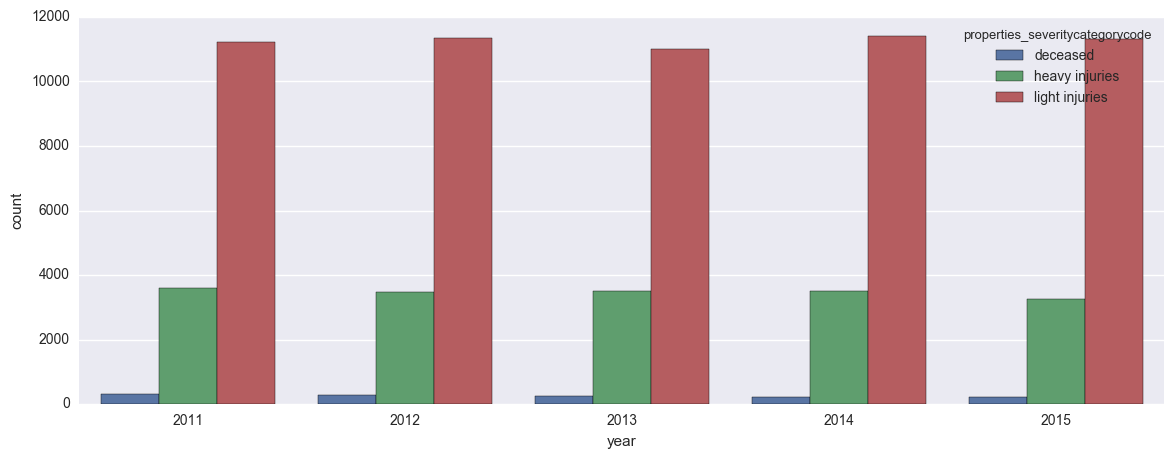

In [17]:
plt.figure(figsize=(14, 5))
sns.countplot(x='year', hue='properties_severitycategorycode', data=accidents_df)

We observe no big variations in accidents in the last 5 years.

In [22]:
accidents_df.year.value_counts(), accidents_df.year.value_counts().mean()

(2014    15145
 2012    15131
 2011    15123
 2015    14826
 2013    14797
 Name: year, dtype: int64, 15004.4)

3602.8


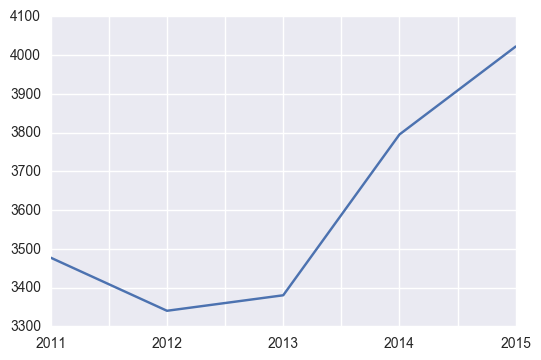

In [38]:
# Bicycle accidents
print(accidents_df[accidents_df.involvesBicycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesBicycles == True].year.value_counts().sort_index().plot()

3915.8


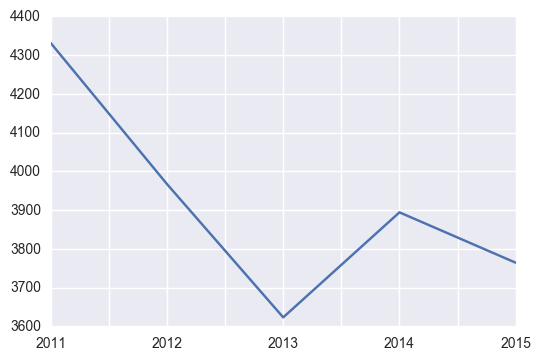

In [39]:
# Motorcycle accidents
print(accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().sort_index().plot()

2336.0


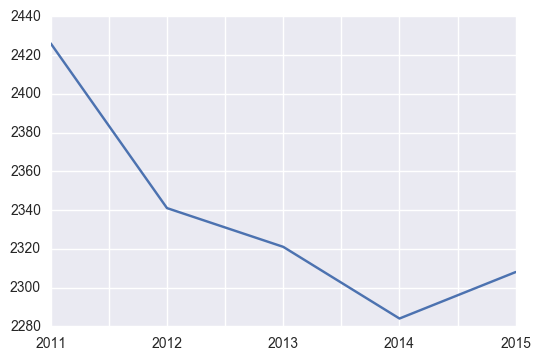

In [41]:
# Pedestrian accidents
print(accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().mean())
accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().sort_index().plot()

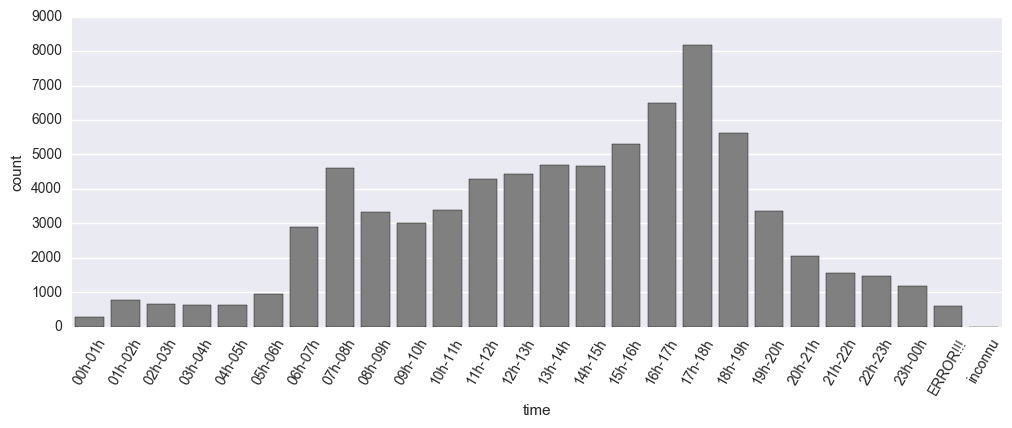

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='time', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

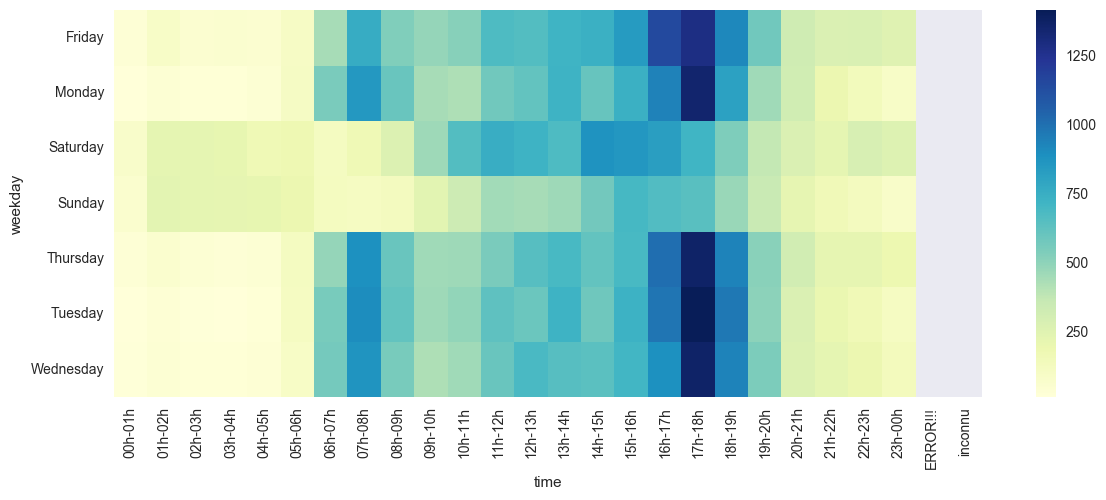

In [80]:
plt.figure(figsize=(14, 5))
time_aware_accidents_df = accidents_df[(accidents_df.time != 'ERROR!!!') & (accidents_df.time != 'inconnu')]
sns.heatmap(time_aware_accidents_df[['time', 'weekday']].reset_index().groupby(('weekday', 'time'), as_index=False).count().pivot('weekday', 'time', 'id'), cmap="YlGnBu")

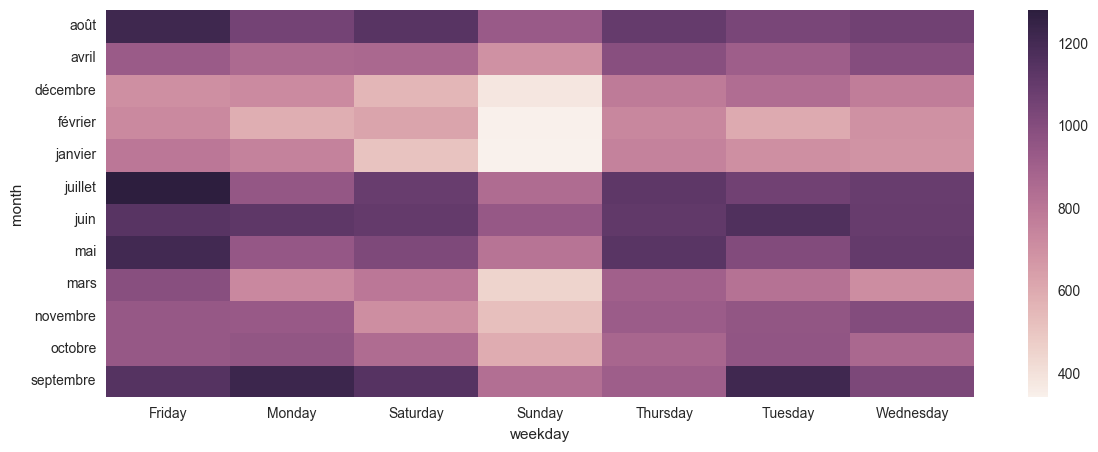

In [333]:
plt.figure(figsize=(14, 5))
sns.heatmap(accidents_df[['weekday', 'month']].reset_index().groupby(('month', 'weekday'), as_index=False).count().pivot('month', 'weekday', 'id'))

In [216]:
accidents_df.to_json('data/accidents.json', orient='index')

In [75]:
%%html
<iframe src="heatmap.html" width="1000px" height="600px"></iframe>

## Grid

Our idea is to create squares all over the swiss map to create areas and then count the accident per area.

Swiss coordinates system is designed so that no two x and y coordinates can be mixed, 1 unit is one meter on the field.

min coord Y : 480000, 070000 (bottom left)
max coord X : 840000, 300000 (top right)

There are squares that are outside Switzerland, but we are not interesting in area with 0 value (as if there are not road there cannot be any accident as well).

In [253]:
xRange=840000-480000
yRange=300000-70000

def create_count_grid(square_size, df):
    """
    Creates and fills an array with the count of accidents per squares
    of size square_size on the map with the provided DataFrame df.
    """
    nb_x = math.ceil(xRange/square_size)
    nb_y = math.ceil(yRange/square_size)
    
    grid = np.zeros((nb_x, nb_y))
    print(nb_x, nb_y, square_size, grid.shape)
    errors = 0
    
    for index, row in df.iterrows():
        x = math.floor((row['geometry_coordinates'][0] - 480000) / square_size)
        y = math.floor((row['geometry_coordinates'][1] - 70000) / square_size)
        grid[x, y] += 1
    print('errors:', errors)
    return grid


def compute_ratio(grid):
    """
    To find a good square size length, we compute a ratio that is (% of non empty squares)/(mean of non zero values)
    """
    non_empty_indices = np.nonzero(grid)
    grid_non_zero = grid[non_empty_indices]
    
    non_empty_pct = len(non_empty_indices) / (grid.shape[0] * grid.shape[1])
    
    mean = grid.mean()
    mean_non_zero = grid_non_zero.mean()
    
    return non_empty_pct / mean_non_zero, non_empty_pct / mean


def optimality_plot(df):
    """
    Plot the result of the ratio per square length
    """
    return [[i, compute_ratio(create_count_grid(i, df))] for i in range (500, 15000, 1000)]

In [254]:
x = optimality_plot(accidents_df)

720 460 500 (720, 460)
errors: 0
240 154 1500 (240, 154)
errors: 0
144 92 2500 (144, 92)
errors: 0
103 66 3500 (103, 66)
errors: 0
80 52 4500 (80, 52)
errors: 0
66 42 5500 (66, 42)
errors: 0
56 36 6500 (56, 36)
errors: 0
48 31 7500 (48, 31)
errors: 0
43 28 8500 (43, 28)
errors: 0
38 25 9500 (38, 25)
errors: 0
35 22 10500 (35, 22)
errors: 0
32 20 11500 (32, 20)
errors: 0
29 19 12500 (29, 19)
errors: 0
27 18 13500 (27, 18)
errors: 0
25 16 14500 (25, 16)
errors: 0


In [256]:
df = pd.DataFrame([[i[0], i[1][0], i[1][1]] for i in x])

In [259]:
df

,0,1,2
0,500,0.000002,0.000027
1,1500,0.000005,0.000027
2,2500,0.000008,0.000027
3,3500,0.000009,0.000027
4,4500,0.000010,0.000027
5,5500,0.000011,0.000027
6,6500,0.000012,0.000027
7,7500,0.000013,0.000027
8,8500,0.000013,0.000027
9,9500,0.000014,0.000027


For poster

In [ ]:
accidents_